In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path

### Part 1: Subset selection method

In [75]:
Hitters = load_data('Hitters').dropna()
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [76]:
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.num((Y - Yhat) ** 2)
    return - (RSS + 2 * p * sigma2) / n

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale
sigma2

99591.35617968219

In [77]:
neg_Cp = partial(nCp, sigma2)
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.predict(Hitters)

1       362.136066
2       712.695206
3      1171.311111
4       556.787508
5       493.251495
          ...     
317     622.944507
318     914.316712
319     243.690976
320    1023.300298
321     705.778067
Length: 263, dtype: float64

In [78]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

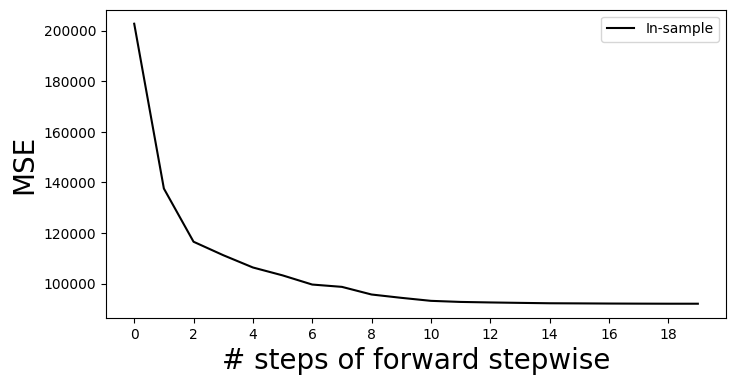

In [12]:
mse_fig, ax = subplots(figsize=(8,4))
insample_mse = ((Yhat_in- Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps), insample_mse, 'k', label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()


In [17]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [16]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx]- Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

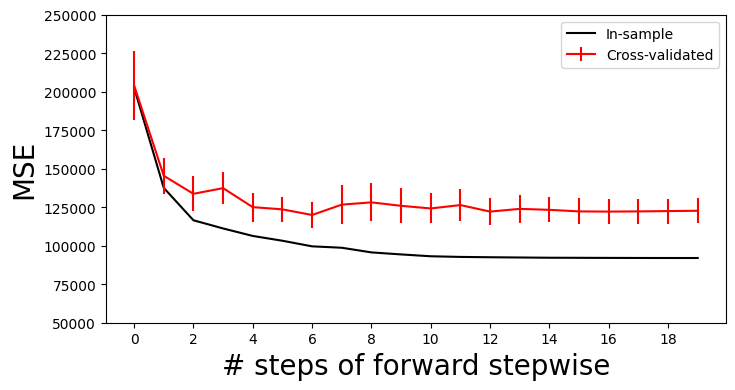

In [18]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K), label='Cross-validated', c='r')
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

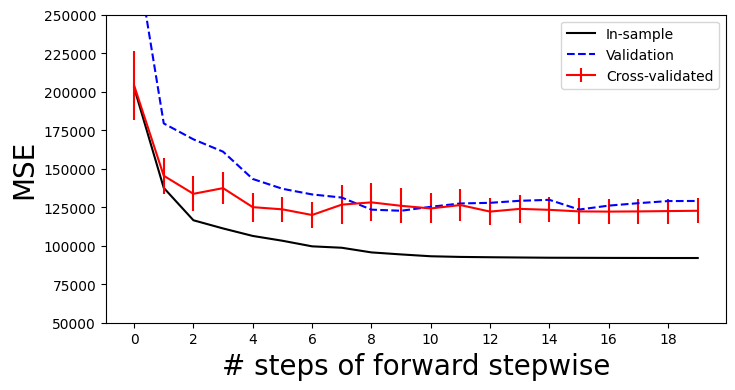

In [79]:
validation = skm.ShuffleSplit(n_splits=1, 
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

ax.plot(np.arange(n_steps), 
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

### Part 2: Ridge and Lasso

In [81]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
X

array([[315.,  81.,   7., ...,  43.,  10.,   1.],
       [479., 130.,  18., ...,  82.,  14.,   0.],
       [496., 141.,  20., ...,  11.,   3.,   1.],
       ...,
       [475., 126.,   3., ..., 113.,   7.,   0.],
       [573., 144.,   9., ..., 131.,  12.,   0.],
       [631., 170.,   9., ...,   4.,   3.,   0.]])

In [ ]:
Xs = X - X.mean(0)
X_scale = X.std(0)
Xs = Xs / X_scale
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]
soln_array.shape

In [88]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


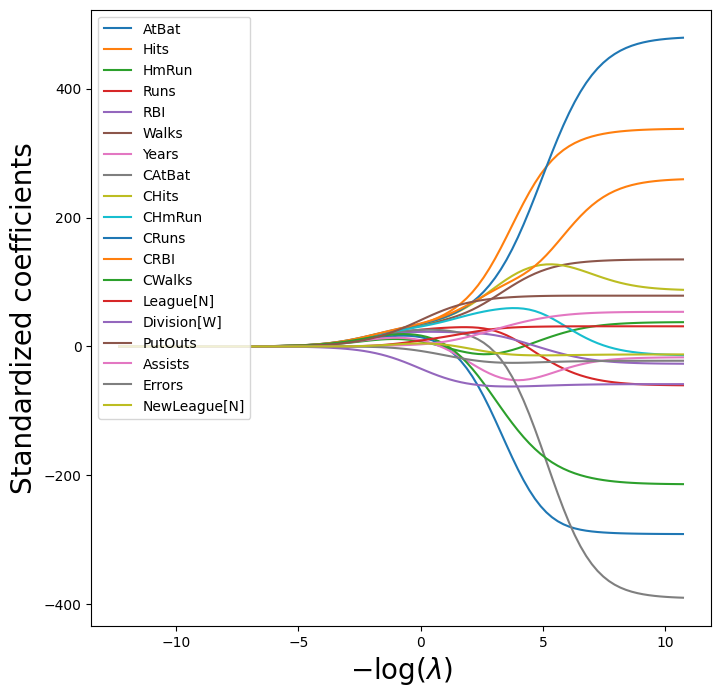

In [89]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

In [92]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], np.linalg.norm(beta_hat)

(25.53538897200662, 24.17061720144378)

In [91]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725912)

In [94]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

array([134214.00419204])

In [95]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [ ]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

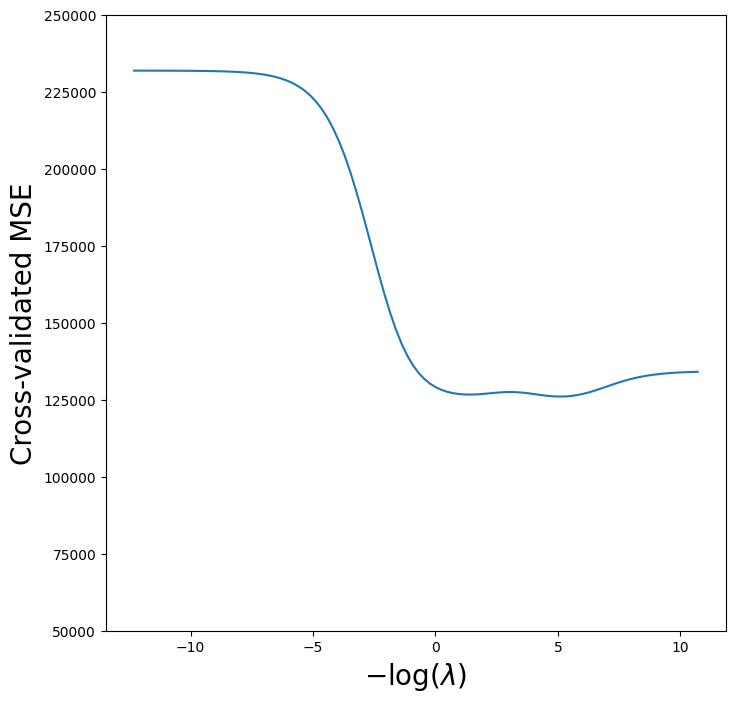

In [97]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);